EDA

Analysis hypothesis:

1) Deforestation presents a seasonal pattern and it occurs on multiple areas accross the Brazilian Amazon.

2) Deforestation areas are usually correspondent to dozens of km squared. This makes the 1km resolution adequate to a spatial modelling approach.

In [1]:
import os
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..//..")

import config
from utils import compute_frames

# H1: Seasonality

In [2]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["date"] = pd.to_datetime(deforestation["date"], format="%Y-%m-%d")

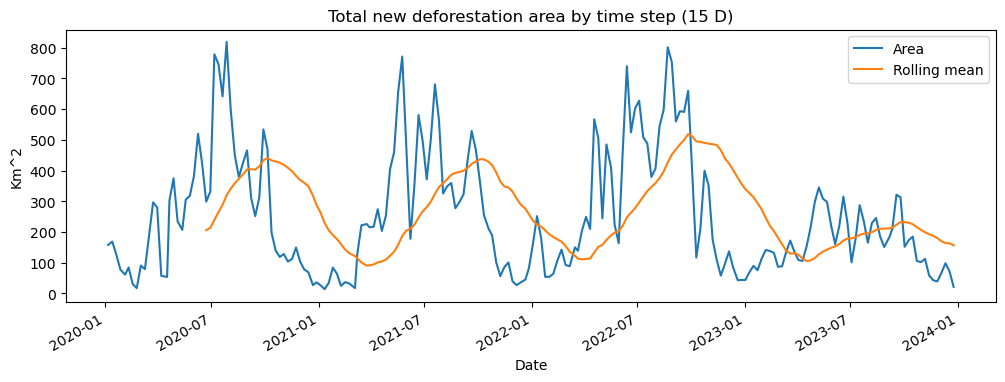

In [3]:
# total deforestation
s = deforestation.groupby("date")["area"].sum().rename("Area")
ax = s.plot(figsize=(12, 4))
s.rolling(24).mean().plot(label="Rolling mean")
ax.set_title("Total new deforestation area by time step (15 D)")
ax.set_xlabel("Date")
ax.set_ylabel("Km^2")
plt.legend()
plt.show()

In [4]:
# lets discard pre-2017 data
deforestation = deforestation[deforestation["date"].dt.year >= 2017].copy()

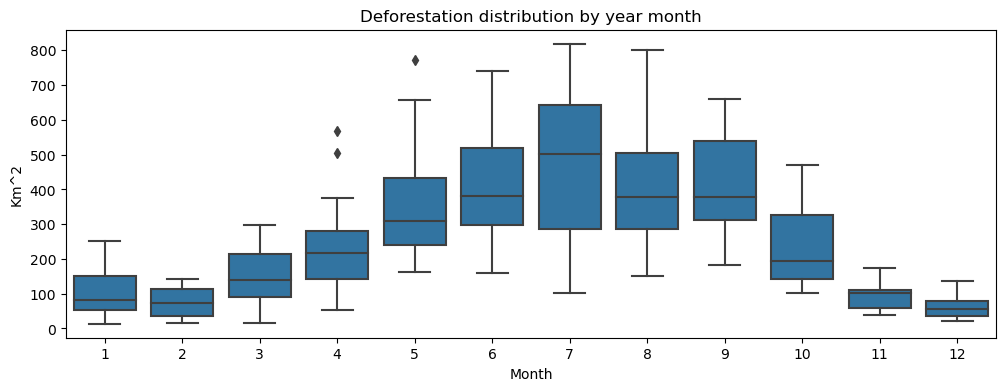

In [5]:
temp = deforestation.groupby("date")["area"].sum().reset_index()
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(
    x=temp["date"].dt.month,
    y=temp["area"],
    color=sns.color_palette()[0]
)
ax.set_title("Deforestation distribution by year month")
ax.set_xlabel("Month")
ax.set_ylabel("Km^2")
plt.show()

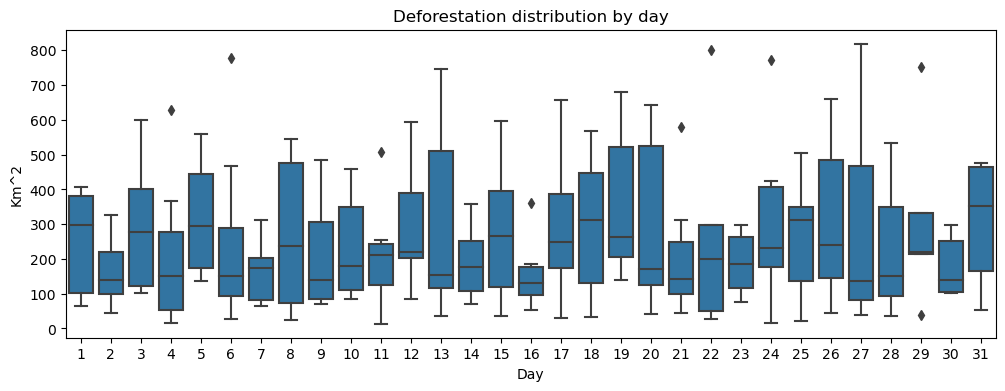

In [6]:
temp = deforestation.groupby("date")["area"].sum().reset_index()
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(
    x=temp["date"].dt.day,
    y=temp["area"],
    color=sns.color_palette()[0]
)
ax.set_title("Deforestation distribution by day")
ax.set_xlabel("Day")
ax.set_ylabel("Km^2")
plt.show()

In [7]:
# seasonality analysis for specific areas
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [8]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [9]:
# get areas with greatest deforestation
defor_area_by_frame = frames_idx.merge(
    deforestation.groupby("frame_id")["area"].sum().reset_index(),
    on="frame_id",
    how="left",
    validate="1:1"
).fillna(0)

In [10]:
# reduce dimensions
defor_area_by_frame["x2"] = defor_area_by_frame["x"] // 100
defor_area_by_frame["y2"] = defor_area_by_frame["y"] // 100
simpl_defor_area = defor_area_by_frame.groupby(["x2", "y2"])["area"].sum().reset_index()

<Axes: xlabel='x2', ylabel='y2'>

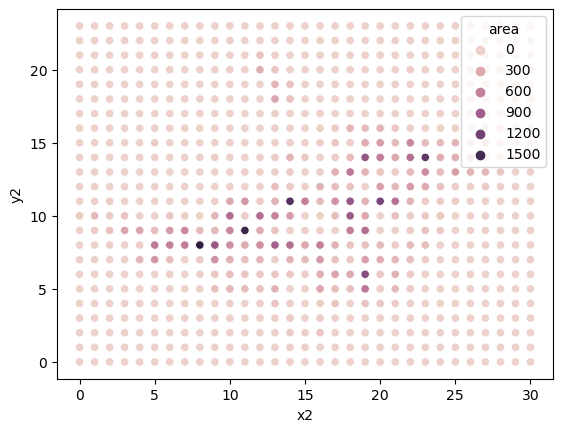

In [11]:
sns.scatterplot(simpl_defor_area, x="x2", y="y2", hue="area")

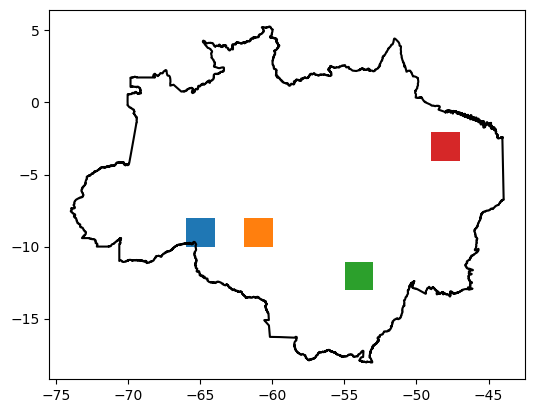

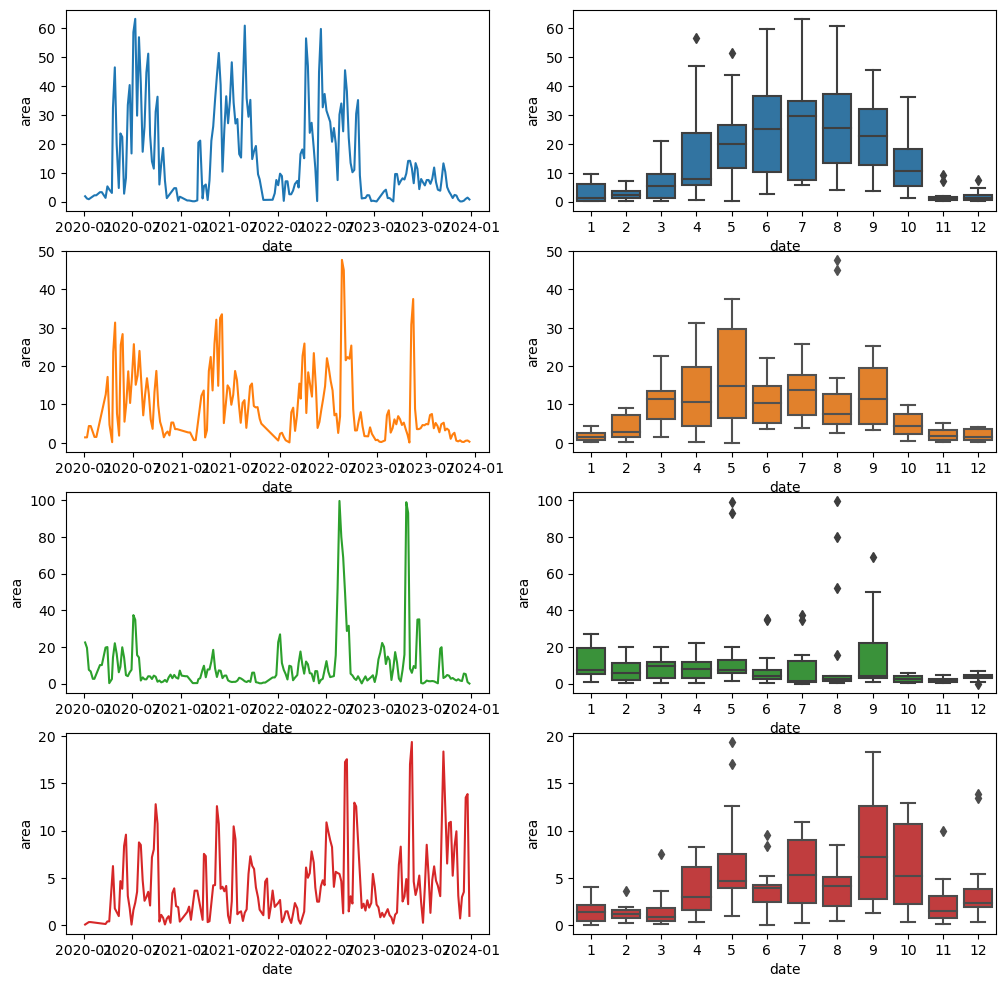

In [12]:
regions = [
    (800, 1000, 800, 1000),
    (1200, 1400, 800, 1000),
    (1900, 2100, 500, 700),
    (2500, 2700, 1400, 1600),
]

fig1, ax1 = plt.subplots()
am_bounds.boundary.plot(ax=ax1, color="black")
fig2, ax2 = plt.subplots(len(regions), 2, figsize=(12, 12))

for ireg, reg in enumerate(regions):
    frames_filtered = frames_idx[
        (frames_idx["x"] >= reg[0]) &
        (frames_idx["x"] < reg[1]) &
        (frames_idx["y"] >= reg[2]) &
        (frames_idx["y"] < reg[3])
    ]

    region_poly = compute_frames(
        am_bounds.total_bounds, 
        config.BOX_SIDE, 
        *reg
    ).unary_union
    gpd.GeoDataFrame(geometry=[region_poly]).plot(ax=ax1, color=sns.color_palette()[ireg])

    region_defor = deforestation[
        deforestation["frame_id"].isin(frames_filtered["frame_id"].values)
    ].groupby("date")["area"].sum().reset_index()
    sns.lineplot(
        region_defor,
        x="date",
        y="area",
        ax=ax2[ireg, 0], 
        color=sns.color_palette()[ireg]
    )
    sns.boxplot(
        x=region_defor["date"].dt.month,
        y=region_defor["area"],
        ax=ax2[ireg, 1],
        color=sns.color_palette()[ireg]
    )

plt.show()

# H2: Spatial pattern

In [13]:
import matplotlib.animation as animation

In [16]:
def generate_deforestation_gif():
    # get deforestation area sample 
    frame_id_ = deforestation.sample()["frame_id"].item()
    x_, y_ = frames_idx[frames_idx["frame_id"] == frame_id_][["x", "y"]].values[0]
    # generate area around it
    poly = compute_frames(
        am_bounds.total_bounds, 
        config.BOX_SIDE, 
        x_ - 64, 
        x_ + 64, 
        y_ - 64,
        y_ + 64
    )

    # create GIF from deforestation evolution
    temp = poly.merge(deforestation, on="frame_id", how="left", validate="1:m")\
        .dropna()
    date_list = config.TIME_STEPS
    ndts = len(date_list)

    fig, ax = plt.subplots()
    poly.boundary.plot(color="black", linewidth=0.0, ax=ax)

    def animate(i):
        temp[temp["date"] <= date_list[i]]\
            .drop("date", axis=1)\
            .dissolve("frame_id", aggfunc="sum")\
            .plot(
                ax=ax, 
                column="area", 
                cmap="Reds",
                vmin=0.0, vmax=1.0
            )
        ax.set_title(date_list[i].date())

    ani = animation.FuncAnimation(fig, animate, repeat=True,
                                        frames=ndts, interval=100)

    # save GIF as html
    html_str = ani.to_jshtml()

    path = os.path.abspath(f'deforestation_evolution_sample_{frame_id_}.html')
    url = 'file://' + path

    with open(path, 'w') as f:
        f.write(html_str)

C:\Users\giovanni\AppData\Local\Temp\ipykernel_2940\1740443544.py:28: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  .plot(
C:\Users\giovanni\AppData\Local\Temp\ipykernel_2940\1740443544.py:28: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  .plot(


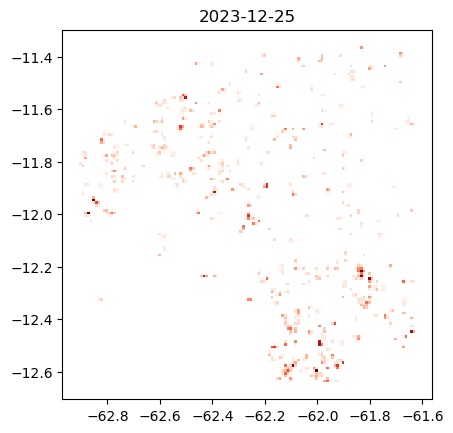

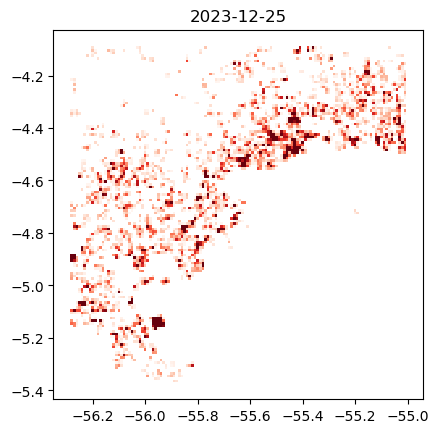

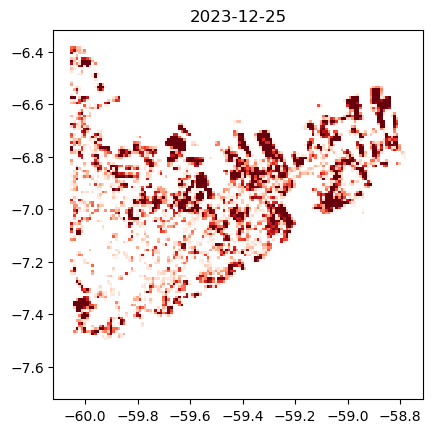

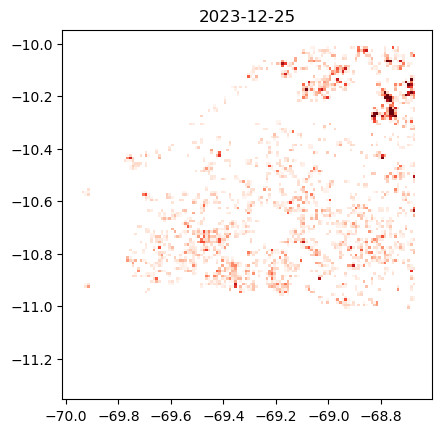

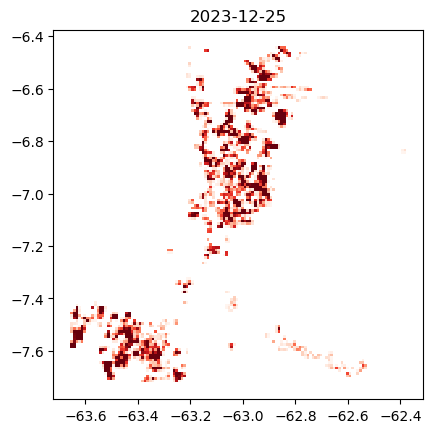

In [17]:
# generate some samples
for _ in range(5):
    generate_deforestation_gif()